# Clean that twitter data!

Use of the "Table of Contents" nbextension is highly recommended.

### Basic imports, settings

In [24]:
import numpy as np
import pandas as pd
import re
import nltk
import os
import json
import sys
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth',100)

### Check variables in memory

In [2]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('np', 80), ('pd', 80)]

## Read data

In [66]:
dir_path = '../data/tweets_London_20km'
data = pd.DataFrame()

print('Loading tweets from', dir_path)
file_names = [file for file in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file))]
for file_name in file_names:
    file_path = dir_path + '/' + file_name
    with open(file_path, 'r', encoding='utf-8') as file:
        tweets = pd.read_json(file)
        data = pd.concat([data, tweets], ignore_index=True)
        
print('Successfully loaded {} tweets from {} files.'.format(len(data), len(file_names)))

Loading tweets from ../data/tweets_London_20km
Successfully loaded 100000 tweets from 100 files.


In [67]:
original_text = data.text
original_text

0        Please support me by voting for me at MAXIM Covergirl 🙏🏼❤️ Link in my Bio or here:\nhttps://t.co...
1        👏👏 Rohit Sharma brings up fifty in his very first innings as a Test opener #INDvSA 👍👍 keep going...
2                                                        Someone take Freddy’s phone https://t.co/XYXR55dk8h
3        According to @AtholT admission, the DA benefited from Steinhoff corruption.\n\nThey not only rec...
4        Thank you for all the applications you sent through on the scholarship announcement. We are now ...
5        @coolstarorg This is how I imagine Coolstar looks when he cosplays as https://t.co/eYLQCihNKg.\n...
6                                               All I can say about life is, Oh God, enjoy it! (Bob Newhart)
7        @justwillhill @issameakaylee @case_burn @califuneral @txtuknee @_freedomperry_ recognition does ...
8                                                                                            @ZZTop Rock On!
9                  

## Clean data

### Lower case, strip

In [68]:
# everything in lower case, strip
data['text'] = data.text.str.lower()
data['text'] = data.text.str.strip()

### Remove tags, usernames, hyperlinks

In [69]:
# remove every #tag 
data['text'] = data.text.str.replace(r'#\S*', '')

In [70]:
# remove every @username
data['text'] = data.text.str.replace(r'@\S*', '')

In [71]:
# remove links
data['text'] = data.text.str.replace(r'http(\S)*', '')

### Remove punctuation

In [72]:
# side note: f*ck those wierdly encoded characters, I'm gonna deal with them in another way... :@
data['text'] = data.text.str.replace(r'[\.,;:?!\(\)\n\t]','')

### Tokenize

In [73]:
from nltk.tokenize import TweetTokenizer

# strip_handles because I'm not sure what it does (maybe removes usernames?),
# reduce_len because I want 'waaaaaay' to be equal to 'waaay'
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

In [74]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tandemelephant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

def token_cleaner(token_list):
    
    stemmer = SnowballStemmer('english')
    stop_words = set(stopwords.words('english'))
    regex = regex = re.compile(r'\w\w+')
    
    tokens = [x for x in token_list if x not in stop_words]
    return list(filter(regex.search, [stemmer.stem(x) for x in tokens]))

In [76]:
tokens = data.text.apply(tokenizer.tokenize).apply(token_cleaner)

In [77]:
all_words = [word for sublist in tokens.values for word in sublist ]

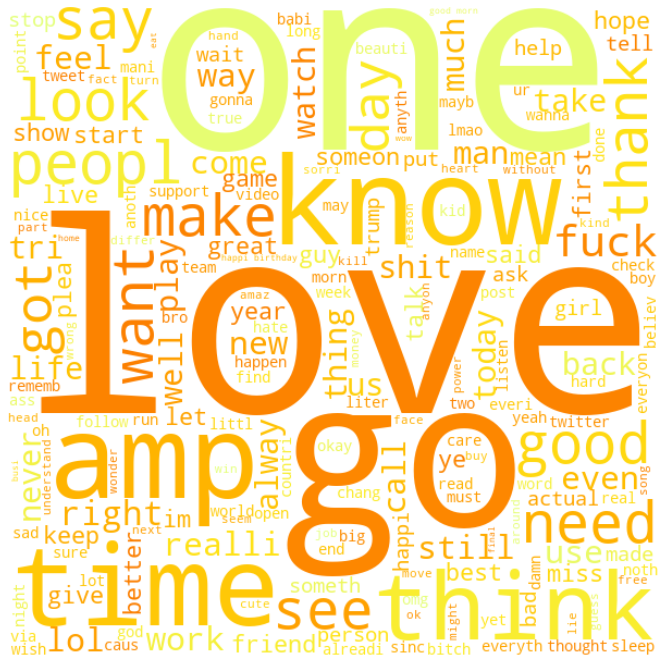

In [79]:
from wordcloud import WordCloud
word_cloud = WordCloud(width = 600, height=600, background_color='white', colormap='Wistia').generate(' '.join(all_words))

fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.savefig('../img/london_cloud.png', facecolor='white')
plt.show()